In [1]:
import os
import pickle
import pandas as pd
import numpy as np
from operator import itemgetter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow import keras
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers, optimizers

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [2]:
def unpickle() :
    for file in os.listdir("dataset") :
        if file == "batches.meta" :
            continue
        file_name = "dataset/" + file
        with open(file_name, 'rb') as fo :
            dict = pickle.load(fo, encoding='latin1')
        data = np.array([dict['data']])
        data = data.reshape((len(dict['data']), 3, 32, 32)).transpose(0, 2, 3, 1)
        label = [dict['labels']]

        return data, label

In [3]:
def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
def vision_data() :
    features, labels = unpickle()
    label_names = load_label_names()

    label_counts = dict(zip(*np.unique(labels, return_counts=True)))
    data_list = []
    num = 6000
    for key, value in label_counts.items():
        print('Label Counts of [{}]({}) : {}'.format(key, label_names[key].upper(), num))
        data_list.append([num, key])


    data_list = sorted(data_list, key=itemgetter(0))
    features_sorted = []
    importance_sorted = []
    for i in data_list :
        features_sorted += [i[1]]
        importance_sorted += [i[0]]
#     print(len(importance_sorted), importance_sorted, features_sorted)

    p1 = plt.barh(range(len(importance_sorted)), importance_sorted)
    plt.bar_label(p1)
    plt.title("Distribution des données dans chaque classe")
    plt.yticks(range(len(importance_sorted)), features_sorted)


Label Counts of [0](AIRPLANE) : 6000
Label Counts of [1](AUTOMOBILE) : 6000
Label Counts of [2](BIRD) : 6000
Label Counts of [3](CAT) : 6000
Label Counts of [4](DEER) : 6000
Label Counts of [5](DOG) : 6000
Label Counts of [6](FROG) : 6000
Label Counts of [7](HORSE) : 6000
Label Counts of [8](SHIP) : 6000
Label Counts of [9](TRUCK) : 6000


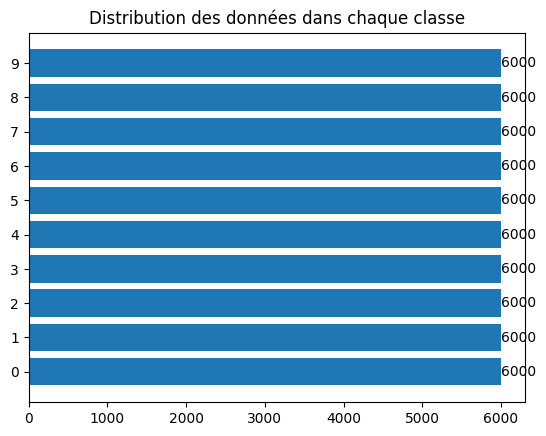

In [5]:
vision_data()

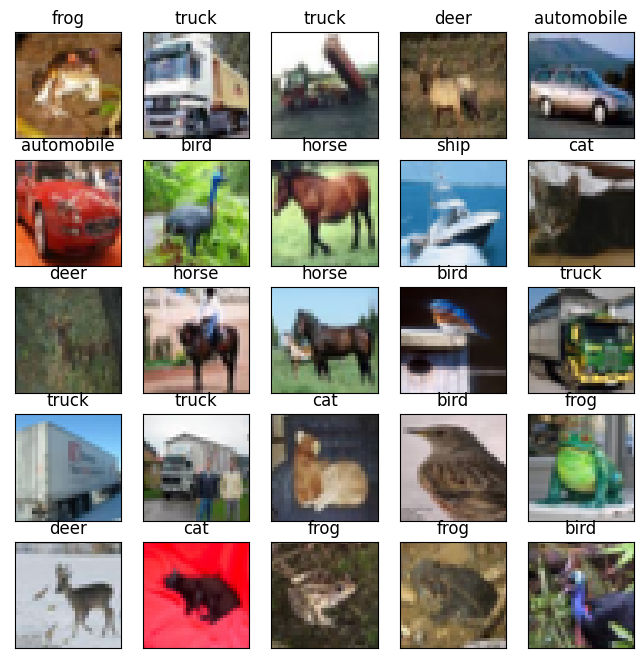

In [6]:
# features, labels = read_data(label_ids=label_ids)
features, labels = unpickle()
label_names = load_label_names()

# print(labels[1])

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i], cmap=plt.cm.binary)
#         print(labels[0][i])

    nom = label_names[labels[0][i]]
    plt.title(nom)

In [7]:
def unpickle_2classes(label_ids: list) :
    for file in os.listdir("datataset") :
        if file == "batches.meta" :
            continue
        file_name = "datataset/" + file
        with open(file_name, 'rb') as fo :
            dict = pickle.load(fo, encoding='latin1')

        wanted = [i for i, v in enumerate(dict['labels']) if v in label_ids]
        data = np.array([dict['data'][x] for x in wanted])
        data = data.reshape((len(data), 3, 32, 32)).transpose(0, 2, 3, 1)
        label = [dict['labels'][x] for x in wanted]

        return data, label

In [8]:
def read_data(label_ids: list):
    all_desired_data = []
    all_desired_label = []

    for file in os.listdir('dataset'):
        file_name = "dataset/" + file
        if file == "batches.meta":
            continue
        with open(file_name, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='bytes')

        desired_data_ids = [i for i, v in enumerate(data_dict[b'labels']) if v in label_ids]

        desired_data = [data_dict[b'data'][x] for x in desired_data_ids]
        desired_label = [data_dict[b'labels'][x] for x in desired_data_ids]
        all_desired_data += desired_data
        all_desired_label += desired_label

    all_desired_data = np.array(all_desired_data)
    all_desired_data = all_desired_data.reshape((len(all_desired_data), 3, 32, 32)).transpose(0, 2, 3, 1)


    return all_desired_data, all_desired_label

label_ids = [2, 5]
features, labels = read_data(label_ids=label_ids)

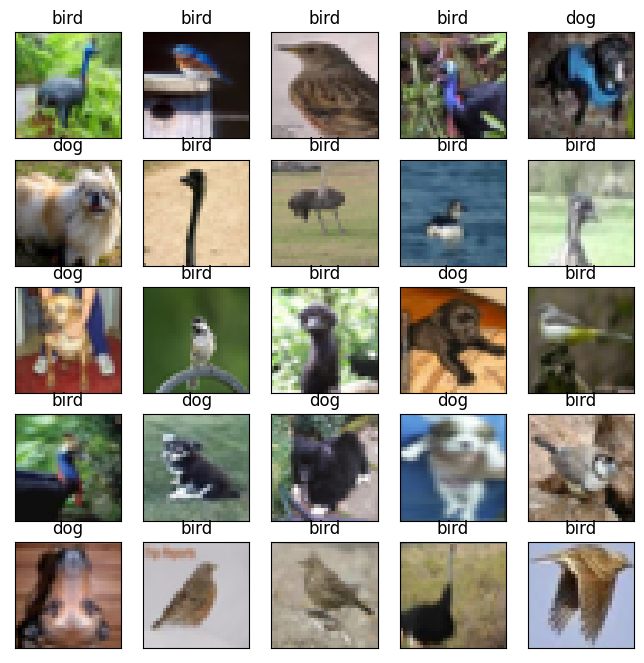

In [9]:
features, labels = read_data(label_ids=label_ids)
# features, labels = unpickle()
label_names = load_label_names()

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i], cmap=plt.cm.binary)
#         print(labels[0][i])

    nom = label_names[labels[i]]
    plt.title(nom)

In [10]:
def changer_name(labels) :
    for i in range(len(labels)) :
    #     print(i)
        if labels[i] == 2 :
    #         print("oui")
            labels[i] = 0 #oiseau devient 0
        elif labels[i] == 5 :
            labels[i] = 1 #chien devient 1
    return labels

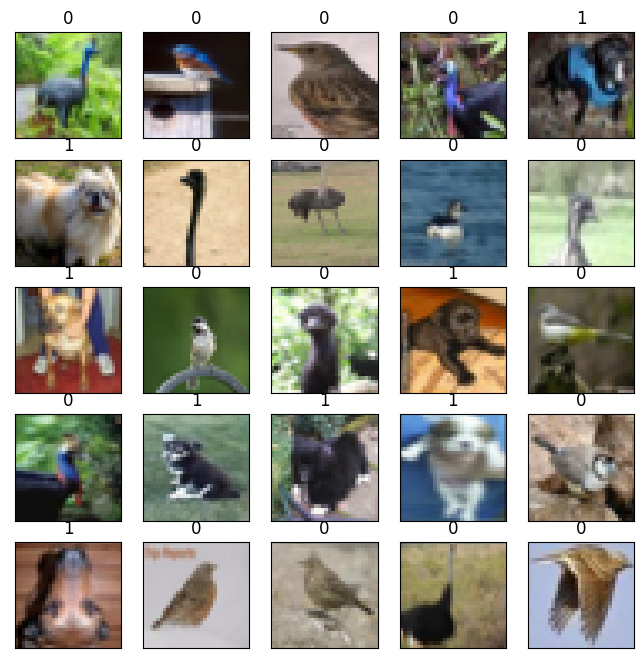

In [11]:
labels = changer_name(labels)

plt.figure(figsize=(8, 8))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i], cmap=plt.cm.binary)
#     print(labels[i])
    plt.title(labels[i])

In [12]:
def normalize(x):
    min_val = np.min(x)
    max_val = np.max(x)
    x = (x-min_val) / (max_val-min_val)
    x = np.array(x)
    return x

In [13]:
def split_data(x, y):

    x_train_validate, x_test, y_train_validate, y_test = train_test_split(x, y, test_size=0.15, random_state=0, stratify=y)
    x_train, x_validate, y_train, y_validate = train_test_split(x_train_validate, y_train_validate, test_size=(15*len(x))/(100*len(x_train_validate)+1), random_state=0, stratify=y_train_validate)
    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]


In [14]:
def preparation(features, labels, label_ids: list):

    features, labels = read_data(label_ids=label_ids)
#     labels = changer_name(labels)
    train_origin, test_origin, validate_origin = split_data(features, labels)

    x_train = normalize(train_origin[0])
    x_test = normalize(test_origin[0])
    x_validate = normalize(validate_origin[0])

#     y_train = keras.utils.to_categorical(train_origin[1], 1)
#     y_test = keras.utils.to_categorical(test_origin[1], 1)
#     y_validate = keras.utils.to_categorical(validate_origin[1], 1)

    y_train = np.array(train_origin[1])
    y_test = np.array(test_origin[1])
    y_validate = np.array(validate_origin[1])

    nsamples = y_train.shape
    y_train = y_train.reshape(int(nsamples[0]),1)

    nsamples = y_test.shape
    y_test = y_test.reshape(int(nsamples[0]),1)

    nsamples = y_validate.shape
    y_validate = y_validate.reshape(int(nsamples[0]),1)

    print('shape X train : ', x_train.shape)
    print('shape X test : ', x_test.shape)
    print('shape X validate : ', x_validate.shape)
    print('shape Y train : ', y_train.shape)
    print('shape Y test : ', y_test.shape)
    print('shape Y validate : ', y_validate.shape)

    return [x_train, y_train], [x_test, y_test], [x_validate, y_validate]

In [15]:
train, test, validate = preparation(features, labels, label_ids = [2, 5])

shape X train :  (8400, 32, 32, 3)
shape X test :  (1800, 32, 32, 3)
shape X validate :  (1800, 32, 32, 3)
shape Y train :  (8400, 1)
shape Y test :  (1800, 1)
shape Y validate :  (1800, 1)


In [16]:
train, test, validate = preparation(features, labels, label_ids = [2, 5])
num_classes = 6

y_train = keras.utils.to_categorical(train[1], num_classes)
y_test = keras.utils.to_categorical(test[1], num_classes)
y_validate = keras.utils.to_categorical(validate[1], num_classes)

x_train = train[0]
x_test = test[0]
x_validate = validate[0]

shape X train :  (8400, 32, 32, 3)
shape X test :  (1800, 32, 32, 3)
shape X validate :  (1800, 32, 32, 3)
shape Y train :  (8400, 1)
shape Y test :  (1800, 1)
shape Y validate :  (1800, 1)


In [17]:
len

<function len(obj, /)>

In [18]:
def pre_graph(data) :
    features_sorted = []
    importance_sorted = []
    oiseau = 0
    chien = 0
    for i in data[1] :
        if i[0] == 2 :
            oiseau += 1
        else :
            chien += 1
    importance_sorted = [oiseau, chien]
    features_sorted = ["oiseau", "chien"]

    return importance_sorted, features_sorted

In [19]:
c = ['black', 'orange']

([<matplotlib.axis.XTick at 0x19567727ca0>,
 [Text(0, 0, 'oiseau'), Text(1, 0, 'chien')])

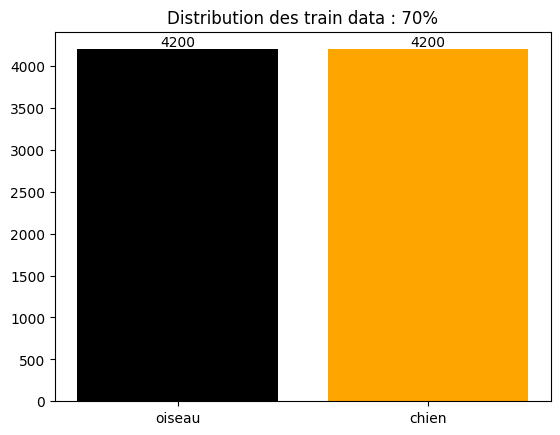

In [20]:
importance_sorted, features_sorted = pre_graph(train)
p2 = plt.bar(range(len(importance_sorted)), importance_sorted, color = c)
plt.bar_label(p2)
plt.title("Distribution des train data : 70%")
plt.xticks(range(len(importance_sorted)), features_sorted)

([<matplotlib.axis.XTick at 0x1956827c910>,
 [Text(0, 0, 'oiseau'), Text(1, 0, 'chien')])

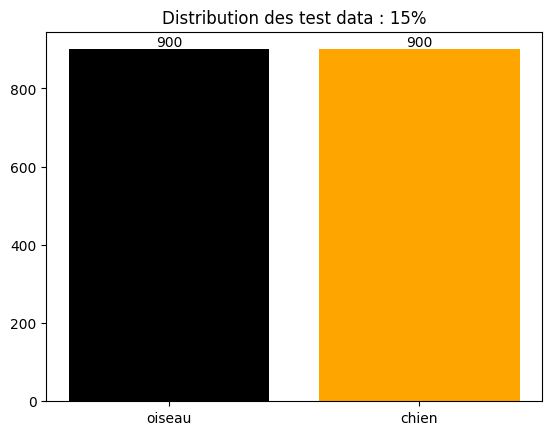

In [21]:
importance_sorted, features_sorted = pre_graph(test)
p3 = plt.bar(range(len(importance_sorted)), importance_sorted, color = c)
plt.bar_label(p3)
plt.title("Distribution des test data : 15%")
plt.xticks(range(len(importance_sorted)), features_sorted)

([<matplotlib.axis.XTick at 0x195678301c0>,
 [Text(0, 0, 'oiseau'), Text(1, 0, 'chien')])

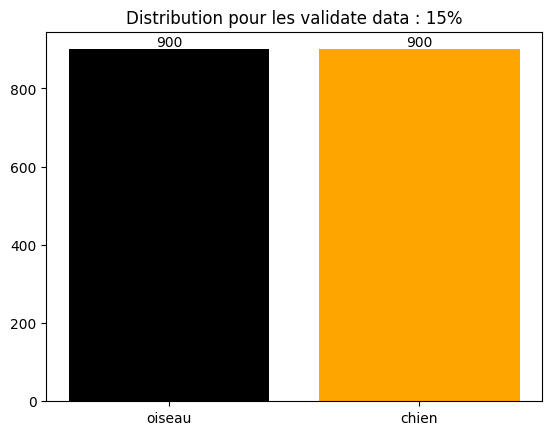

In [22]:
# plt.figsize=(20,10)
importance_sorted, features_sorted = pre_graph(validate)
p4 = plt.bar(range(len(importance_sorted)), importance_sorted, color = c)
plt.bar_label(p4)
plt.title("Distribution pour les validate data : 15%")
plt.xticks(range(len(importance_sorted)), features_sorted)

## Regression linéaire

In [23]:
def mettre_list (data) :
    listes = []
    for i in range(len(data)) :
        listes.append(int(data[i]))

    return listes

def changer_name(labels) :
    for i in range(len(labels)) :
    #     print(i)
        if labels[i] == 2 :
    #         print("oui")
            labels[i] = 0 #oiseau devient 0
        elif labels[i] == 5 :
            labels[i] = 1 #chien devient 1
    return labels

In [24]:
x_train = train[0].reshape(train[0].shape[0], 32*32*3)
x_test = test[0].reshape(test[0].shape[0], 32*32*3)
y_train = mettre_list(train[1])
y_test = mettre_list(test[1])
# print(y_train)
y_train = changer_name(y_train)
y_test = changer_name(y_test)

start_time = time.time()

regressor = LinearRegression()
hist2 = regressor.fit(x_train, y_train)
end_time = time.time()

print(regressor.intercept_)
pd.DataFrame(regressor.coef_)
print(pd.DataFrame(regressor.coef_))

elapsed_time_rl = end_time - start_time
elapsed_time_rl = round(elapsed_time_rl, 3)
print("Elapsed time:", elapsed_time_rl)


0.3165304274670433
             0
0    -0.393849
1    -0.174174
2     0.592872
3    -0.239608
4     0.473934
...        ...
3067 -1.267333
3068  1.427958
3069  0.496559
3070  0.114170
3071 -0.637991

[3072 rows x 1 columns]
Elapsed time: 21.709


In [25]:
y_pred = regressor.predict(x_test)
y_pred = [np.round(x) for x in y_pred]


for i in range(len(y_pred)) :
    if y_pred[i] == -1.0 :
        y_pred[i] = 1
    elif y_pred[i] == -0.0 :
        y_pred[i] = 0

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
df

,Actual,Predicted
0,1,1.0
1,1,1.0
2,1,1.0
3,0,0.0
4,1,1.0
...,...,...
1795,0,1.0
1796,1,1.0
1797,0,1.0
1798,1,1.0


In [26]:
# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
# print("Explain variance score =", metrics.explained_variance_score(y_test, y_pred))
print("R2 score =", metrics.r2_score(y_test, y_pred))

Mean Squared Error: 0.4077777777777778
R2 score = -0.6311111111111112


In [27]:
metrics.accuracy_score(y_test, y_pred)

rl = metrics.accuracy_score(y_test, y_pred)

rl

0.61

# Knn

In [28]:
def get_accuracy(predictions, actual):
    difference = predictions - actual
    number_predictions = predictions.shape[0]
    number_incorrect = np.count_nonzero(difference)
    number_correct = number_predictions - number_incorrect
    accuracy = number_correct / number_predictions
    return accuracy

In [29]:
classifier = KNeighborsClassifier(n_neighbors=5)
accuracies = []
kf = KFold(n_splits=5, shuffle=True)
x_train = train[0].reshape(train[0].shape[0], 32*32*3)
x_test = test[0].reshape(test[0].shape[0], 32*32*3)
y_train = mettre_list(train[1])
y_test = mettre_list(test[1])
# print(y_train)
y_train = changer_name(y_train)
y_test = changer_name(y_test)

start_time = time.time()

classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
accuracy = get_accuracy(y_predict, y_test)
accuracies.append(accuracy)
end_time = time.time()

mean_accuracy = np.array(accuracies).mean()
mean_accuracy = round(mean_accuracy, 3)
print("Mean accuracy:", mean_accuracy)

knn = mean_accuracy

Mean accuracy: 0.678


In [30]:
elapsed_time_knn = end_time - start_time
elapsed_time_knn = round(elapsed_time_knn, 3)
print("Elapsed time:", elapsed_time_knn)

Elapsed time: 2.035


## CNN


In [31]:
train, test, validate = preparation(features, labels, label_ids = [2, 5])
num_classes = 6

y_train = keras.utils.to_categorical(train[1], num_classes)
y_test = keras.utils.to_categorical(test[1], num_classes)
y_validate = keras.utils.to_categorical(validate[1], num_classes)

x_train = train[0]
x_test = test[0]
x_validate = validate[0]

shape X train :  (8400, 32, 32, 3)
shape X test :  (1800, 32, 32, 3)
shape X validate :  (1800, 32, 32, 3)
shape Y train :  (8400, 1)
shape Y test :  (1800, 1)
shape Y validate :  (1800, 1)


In [32]:
def covnet(baseMapNum = 64, weight_decay = 1e-4):
    keras.backend.clear_session()
    model = Sequential()
    model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.45))

    model.add(Flatten())
    model.add(Dense(6, activation='softmax'))

    model.summary()

    return model

In [33]:
model = covnet()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 activation_1 (Activation)   (None, 32, 32, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                        

In [34]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zoom_range=[0.8,1.4],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(train[0])

In [ ]:
optz = keras.optimizers.RMSprop(learning_rate=0.0007,decay=1e-6)
batch_size = 64
steps_epoch=2*x_train.shape[0]
epochs = 30

model.compile(loss='categorical_crossentropy', optimizer=optz, metrics=['accuracy'])
callback = [keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=4, restore_best_weights=True)]

start_time = time.time()

# Fit the model on the batches generated by datagen.flow().
hist1 = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    validation_data=(x_validate, y_validate),
                    epochs=epochs, verbose=0, callbacks=callback)

end_time = time.time()

model.save_weights('cifar10_ep{}.h5'.format(len(hist1.history['loss'])))


In [ ]:
elapsed_time_cnn = end_time - start_time
elapsed_time_cnn = round(elapsed_time_cnn, 3)
print("Elapsed time:", elapsed_time_cnn)

In [ ]:
def plot_model_result(model_fit):
    plt.subplot(2, 1, 1)
    plt.plot(model_fit.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='lower right')

    plt.subplot(2, 1, 2)
    plt.plot(model_fit.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper right')
    plt.tight_layout()

In [ ]:
hist1.history['accuracy']

In [ ]:
plot_model_result(hist1)

In [ ]:
acc = hist1.history['accuracy']
print("Taux de réussite de : ", max(acc))
cnn = max(acc)

# Comparaison

In [ ]:
# knn
# rl = 0.5
# cnn = 0.80
final = []

final = np.array([["cnn", cnn], ["regression linéaire", rl], ["knn", knn]])
df = pd.DataFrame(final, columns=['Model', 'Accuracy'])
df = df.sort_values(by="Accuracy", ascending=True)
df['Accuracy']=df['Accuracy'].astype(float)
ax = df.plot.barh(x='Model', y='Accuracy')
ax.set_xscale('log')
ax.bar_label(ax.containers[0])
plt.title("Comparaison des taux de précisions des modèles")
plt.show()

In [ ]:
final = []
final = np.array([["cnn", elapsed_time_cnn], ["regression linéaire", elapsed_time_rl], ["knn", elapsed_time_knn]])
df = pd.DataFrame(final, columns=['Model', 'Temps'])
df = df.sort_values(by="Temps", ascending=True)
df['Temps']=df['Temps'].astype(float)
ax = df.plot.barh(x='Model', y='Temps')
ax.set_xscale('log')
ax.bar_label(ax.containers[0])
plt.title("Comparaison des temps d'exécution des modèles (en secondes)")
plt.show()

In [ ]:
def plot_confusion_matrix(model_to_plot, test_data):
    y_pred = model_to_plot.predict(test_data[0])
    y_pred_label = np.argmax(y_pred, 1)
    y_test_label = list(test_data[1])



    mat = confusion_matrix(y_test_label, y_pred_label)
    cmd = ConfusionMatrixDisplay(confusion_matrix=mat.T)
    fig, ax1 = plt.subplots(figsize=(8, 8))
    cmd.plot(cmap=plt.cm.Blues, ax=ax1)

    return y_pred_label, y_test_label

In [ ]:
Y_pred, Y_test = plot_confusion_matrix(model, test)

In [ ]:
def display_errors(label_pred, label_test, data_test):
    label_test = np.argmax(label_test, 1)
    label_test = label_test
    errors = (label_pred - label_test != 0)
    Y_pred_errors_class = label_pred[errors]  # [1, 2, 3, 5, 9, ....]
    Y_test_errors_class = label_test[errors]  # [2, 2, 3, 5, 9, ....]
    X_test_errors = data_test[errors]
    fig, ax3 = plt.subplots(1, 1, figsize=(10, 7))

    error_index = np.where(Y_test_errors_class == 2)
    error_index = np.random.choice(error_index[0], size=1)
#     print(X_test_errors[error_index][0])
    ax3.imshow((X_test_errors[error_index]).reshape((32, 32, 3)), cmap=plt.cm.binary)
    ax3.set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))

#     print(Y_test_errors_class)
#     for row in range(nrows):
#         for col in range(ncols):
#             error_index = np.where(Y_test_errors_class == ncols * row + col)
#             print(error_index)
#             if error_index and len(error_index[0]) != 0:
#                 error_index = np.random.choice(error_index[0], size=1)
#             else:
#                 continue
#             ax3[row, col].imshow((X_test_errors[error_index]).reshape((32, 32)), cmap=plt.cm.binary)
#             ax3[row, col].set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))
#             n += 1

display_errors(Y_pred, y_test, x_test)

In [ ]:
def display_errors5(label_pred, label_test, data_test):
    label_test = np.argmax(label_test, 1)
    label_test = label_test
    errors = (label_pred - label_test != 0)
    Y_pred_errors_class = label_pred[errors]  # [1, 2, 3, 5, 9, ....]
    Y_test_errors_class = label_test[errors]  # [2, 2, 3, 5, 9, ....]
    X_test_errors = data_test[errors]
    fig, ax3 = plt.subplots(1, 1, figsize=(10, 7))

    error_index = np.where(Y_test_errors_class == 5)
    error_index = np.random.choice(error_index[0], size=1)
#     print(X_test_errors[error_index][0])
    ax3.imshow((X_test_errors[error_index]).reshape((32, 32, 3)), cmap=plt.cm.binary)
    ax3.set_title("Predicted label :{}\nTrue label :{}".format(Y_pred_errors_class[error_index], Y_test_errors_class[error_index]))


display_errors5(Y_pred, y_test, x_test)